In [98]:
import os
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const
from scipy import interpolate
from scipy.optimize import minimize
from scipy import optimize as opt
from astropy.cosmology import Planck15  as cosmo# Planck 2015 since that's what TNG uses
from astropy.cosmology import z_at_value
from IPython.display import Image # to open images in Ipython 


############################
# Custom scripts
import get_ZdepSFRD as Z_SFRD
import importlib
import paths
import init_values as In

import ReadFitData as read
importlib.reload(read)

#Change file names to match TNG version
Cosmol_sim_location = paths.data / "SFRMetallicityFromGasTNG50-1.hdf5"
fit_filename = 'best_fit_parameters_TNG50.txt'
rbox = 35 #35 for 50, 75 for 100, 205 for 300

# dP/dlogZ

Low to high resolution:
- Skewness ($\alpha$) decreases (e.g. less negative, less skewed)
- Redshift evolution of variance ($\omega_z$) increases

dP/dlogZ is the probability of getting a particular logZ at a certain redshift (2D array)

- Lower resolution: more skewed distribution, lower redshift evolution of variance ($\alpha=-6, \omega_z=0$)
- Higher resolution: less skewed distribution, higher redshift evolution of variance ($\alpha=0, \omega_z=0.1$)

In [99]:
redshift_list  = np.linspace(0,15, num=100)
fit_param_filename = 'test_best_fit_parameters_TNG50.txt'
mu0, muz, omega0, omegaz, alpha0,sf_a, sf_b, sf_c, sf_d = np.loadtxt(str(paths.data)+'/'+fit_param_filename,unpack=True, delimiter=',')
metal_bins = np.logspace(-10, 0, 61) #60 bins
center_Zbin = (metal_bins[:-1] + metal_bins[1:])/2

Zsun = Zsun = 0.014 # Solar metallicity

## Plot dP/dlogZ vs logZ for binned redshifts

In [100]:
# Create mask for low/middle/high redshift bins

#get dP/dlogZ given fiducial (best fit) values
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = Z_SFRD.skew_metallicity_distribution(redshift_list, mu_z =muz, 
                                mu_0 =mu0, omega_0=omega0,omega_z=omegaz, alpha =alpha0, metals=center_Zbin)

#create mask
lowz = (redshift_list < 2)
midz = ((redshift_list >= 2) & (redshift_list < 4))
highz = ((redshift_list >= 4) & (redshift_list < 6))

#binned dP/dlogZ by redshift
lowz_dPdlogZ = dPdlogZ[:,][lowz]
midz_dPdlogZ = dPdlogZ[:,][midz]
highz_dPdlogZ = dPdlogZ[:,][highz]

#mean dP/dlogZ for each redshift bin
lowz_meanZ = np.mean(mu0 * 10**(muz * redshift_list[lowz]))
midz_meanZ = np.mean(mu0 * 10**(muz * redshift_list[midz]))
highz_meanZ = np.mean(mu0 * 10**(muz * redshift_list[highz]))

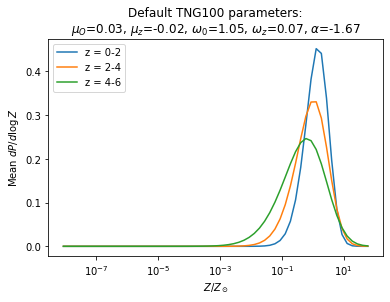

In [101]:
#Plot mean dP/dlogZ vs Z for the fiducial TNG100 parameters

plt.plot(metallicities/Zsun, np.mean(lowz_dPdlogZ, axis=0), label="z = 0-2")
plt.plot(metallicities/Zsun, np.mean(midz_dPdlogZ, axis=0), label="z = 2-4")
plt.plot(metallicities/Zsun, np.mean(highz_dPdlogZ, axis=0), label="z = 4-6")
plt.xlabel(r"$Z/Z_\odot$")
plt.ylabel("Mean " + r"$dP/d\logZ$")
plt.xscale("log")
plt.legend()
plt.title('Default TNG100 parameters:'+'\n'+r'$\mu_O$=%.2f, $\mu_z$=%.2f, $\omega_0$=%.2f, $\omega_z$=%.2f, $\alpha$=%.2f'%(mu0, muz, omega0, omegaz, alpha0));

In [102]:
#Get dP/dlogZ for each variation of the parameters (changing both alpha and omega_z), and bin them

#low skewness, high redshift evol of variance
dPdlogZ1, metallicities1, step_logZ1, p_draw_metallicity1 = Z_SFRD.skew_metallicity_distribution(redshift_list, mu_z =muz, 
                                                        mu_0 =mu0, omega_0=omega0,omega_z=0.1, alpha =0, metals=center_Zbin)

#high skewness, low redshift evol of variance
dPdlogZ2, metallicities2, step_logZ2, p_draw_metallicity2 = Z_SFRD.skew_metallicity_distribution(redshift_list, mu_z =muz, 
                                                        mu_0 =mu0, omega_0=omega0,omega_z=0, alpha =-6, metals=center_Zbin)

lowz_dPdlogZ1 = dPdlogZ1[:,][lowz]
midz_dPdlogZ1 = dPdlogZ1[:,][midz]
highz_dPdlogZ1 = dPdlogZ1[:,][highz]

lowz_dPdlogZ2 = dPdlogZ2[:,][lowz]
midz_dPdlogZ2 = dPdlogZ2[:,][midz]
highz_dPdlogZ2 = dPdlogZ2[:,][highz]

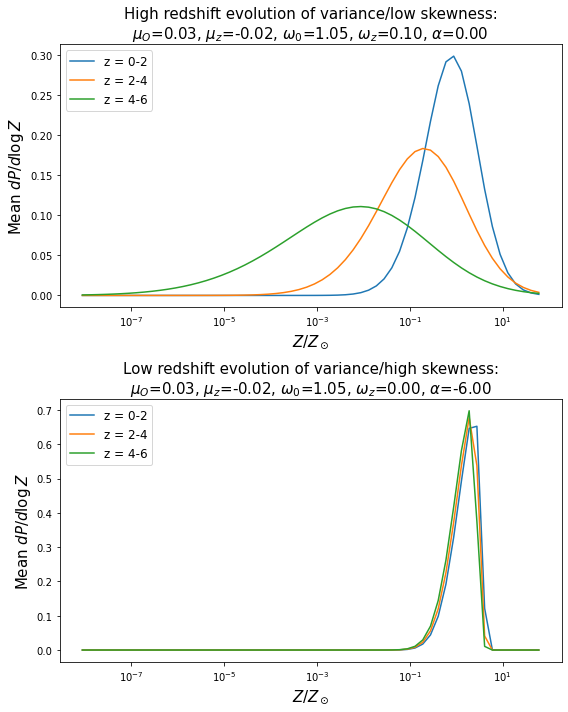

In [103]:
#Plot the parameter variations for high (top) and low (bottom) resolution

fig, ax = plt.subplots(2, 1, figsize=(8, 10))

ax[0].plot(metallicities/Zsun, np.mean(lowz_dPdlogZ1, axis=0), label="z = 0-2")
ax[0].plot(metallicities/Zsun, np.mean(midz_dPdlogZ1, axis=0), label="z = 2-4")
ax[0].plot(metallicities/Zsun, np.mean(highz_dPdlogZ1, axis=0), label="z = 4-6")
ax[0].set_xlabel(r"$Z/Z_\odot$", fontsize=15)
ax[0].set_ylabel("Mean " + r"$dP/d\logZ$", fontsize=15)
ax[0].set_xscale("log")
ax[0].legend(fontsize=12)
ax[0].set_title('High redshift evolution of variance/low skewness:'+'\n'+r'$\mu_O$=%.2f, $\mu_z$=%.2f, $\omega_0$=%.2f, $\omega_z$=%.2f, $\alpha$=%.2f'%(mu0, muz, omega0, 0.1, 0), fontsize=15);

ax[1].plot(metallicities/Zsun, np.mean(lowz_dPdlogZ2, axis=0), label="z = 0-2")
ax[1].plot(metallicities/Zsun, np.mean(midz_dPdlogZ2, axis=0), label="z = 2-4")
ax[1].plot(metallicities/Zsun, np.mean(highz_dPdlogZ2, axis=0), label="z = 4-6")
ax[1].set_xlabel(r"$Z/Z_\odot$", fontsize=15)
ax[1].set_ylabel("Mean " + r"$dP/d\logZ$", fontsize=15)
ax[1].set_xscale("log")
ax[1].legend(fontsize=12)
ax[1].set_title('Low redshift evolution of variance/high skewness:'+'\n'+r'$\mu_O$=%.2f, $\mu_z$=%.2f, $\omega_0$=%.2f, $\omega_z$=%.2f, $\alpha$=%.2f'%(mu0, muz, omega0, 0,-6), fontsize=15);

fig.tight_layout()
fig.savefig('figures/checking_fit/parameter_variations_resolutions.png', bbox_inches='tight')

In [104]:
##Get dP/dlogZ for each variation of the parameters (one at a time), and bin them

#high omega_z
dPdlogZ3, metallicities3, step_logZ3, p_draw_metallicity3 = Z_SFRD.skew_metallicity_distribution(redshift_list, mu_z =muz, 
                                                        mu_0 =mu0, omega_0=omega0,omega_z=0.1, alpha =alpha0, metals=center_Zbin)
#low omega_z
dPdlogZ4, metallicities4, step_logZ4, p_draw_metallicity4 = Z_SFRD.skew_metallicity_distribution(redshift_list, mu_z =muz, 
                                                        mu_0 =mu0, omega_0=omega0,omega_z=0, alpha =alpha0, metals=center_Zbin)
#high alpha
dPdlogZ5, metallicities5, step_logZ5, p_draw_metallicity5 = Z_SFRD.skew_metallicity_distribution(redshift_list, mu_z =muz, 
                                                        mu_0 =mu0, omega_0=omega0,omega_z=omegaz, alpha =-6, metals=center_Zbin)
#low alpha
dPdlogZ6, metallicities6, step_logZ6, p_draw_metallicity6 = Z_SFRD.skew_metallicity_distribution(redshift_list, mu_z =muz, 
                                                        mu_0 =mu0, omega_0=omega0,omega_z=omegaz, alpha =0, metals=center_Zbin)

lowz_dPdlogZ3 = dPdlogZ3[:,][lowz]
midz_dPdlogZ3 = dPdlogZ3[:,][midz]
highz_dPdlogZ3 = dPdlogZ3[:,][highz]

lowz_dPdlogZ4 = dPdlogZ4[:,][lowz]
midz_dPdlogZ4 = dPdlogZ4[:,][midz]
highz_dPdlogZ4 = dPdlogZ4[:,][highz]

lowz_dPdlogZ5 = dPdlogZ5[:,][lowz]
midz_dPdlogZ5 = dPdlogZ5[:,][midz]
highz_dPdlogZ5 = dPdlogZ5[:,][highz]

lowz_dPdlogZ6 = dPdlogZ6[:,][lowz]
midz_dPdlogZ6 = dPdlogZ6[:,][midz]
highz_dPdlogZ6 = dPdlogZ6[:,][highz]

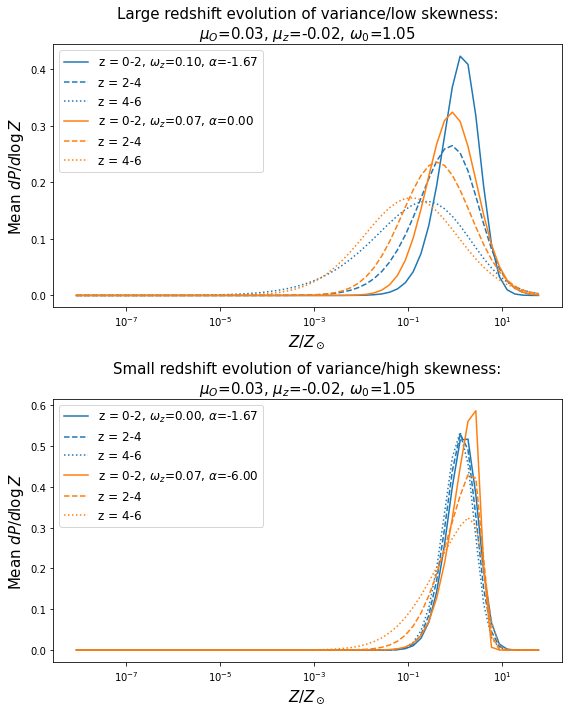

In [105]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

ax[0].plot(metallicities/Zsun, np.mean(lowz_dPdlogZ3, axis=0), c='tab:blue', linestyle='-', label=r"z = 0-2, $\omega_z$=%.2f, $\alpha$=%.2f"%(0.1, alpha0))
ax[0].plot(metallicities/Zsun, np.mean(midz_dPdlogZ3, axis=0), c='tab:blue', linestyle='--', label="z = 2-4")
ax[0].plot(metallicities/Zsun, np.mean(highz_dPdlogZ3, axis=0), c='tab:blue', linestyle=':', label="z = 4-6")
ax[0].plot(metallicities/Zsun, np.mean(lowz_dPdlogZ6, axis=0), c='tab:orange', linestyle='-', label=r"z = 0-2, $\omega_z$=%.2f, $\alpha$=%.2f"%(omegaz, 0))
ax[0].plot(metallicities/Zsun, np.mean(midz_dPdlogZ6, axis=0), c='tab:orange', linestyle='--', label="z = 2-4")
ax[0].plot(metallicities/Zsun, np.mean(highz_dPdlogZ6, axis=0), c='tab:orange', linestyle=':', label="z = 4-6")
ax[0].set_xlabel(r"$Z/Z_\odot$", fontsize=15)
ax[0].set_ylabel("Mean " + r"$dP/d\logZ$", fontsize=15)
ax[0].set_xscale("log")
ax[0].legend(fontsize=12)
ax[0].set_title('Large redshift evolution of variance/low skewness:'+'\n'+r'$\mu_O$=%.2f, $\mu_z$=%.2f, $\omega_0$=%.2f'%(mu0, muz, omega0), fontsize=15);

ax[1].plot(metallicities/Zsun, np.mean(lowz_dPdlogZ4, axis=0), c='tab:blue', linestyle='-', label=r"z = 0-2, $\omega_z$=%.2f, $\alpha$=%.2f"%(0, alpha0))
ax[1].plot(metallicities/Zsun, np.mean(midz_dPdlogZ4, axis=0), c='tab:blue', linestyle='--', label="z = 2-4")
ax[1].plot(metallicities/Zsun, np.mean(highz_dPdlogZ4, axis=0), c='tab:blue', linestyle=':', label="z = 4-6")
ax[1].plot(metallicities/Zsun, np.mean(lowz_dPdlogZ5, axis=0), c='tab:orange', linestyle='-', label=r"z = 0-2, $\omega_z$=%.2f, $\alpha$=%.2f"%(omegaz, -6))
ax[1].plot(metallicities/Zsun, np.mean(midz_dPdlogZ5, axis=0), c='tab:orange', linestyle='--', label="z = 2-4")
ax[1].plot(metallicities/Zsun, np.mean(highz_dPdlogZ5, axis=0), c='tab:orange', linestyle=':', label="z = 4-6")
ax[1].set_xlabel(r"$Z/Z_\odot$", fontsize=15)
ax[1].set_ylabel("Mean " + r"$dP/d\logZ$", fontsize=15)
ax[1].set_xscale("log")
ax[1].legend(fontsize=12)
ax[1].set_title('Small redshift evolution of variance/high skewness:'+'\n'+r'$\mu_O$=%.2f, $\mu_z$=%.2f, $\omega_0$=%.2f'%(mu0, muz, omega0), fontsize=15);

fig.tight_layout()
fig.savefig('figures/checking_fit/parameter_variations_binned.png', bbox_inches='tight')

## Plot dP/dlogZ vs logZ as a 2D plot

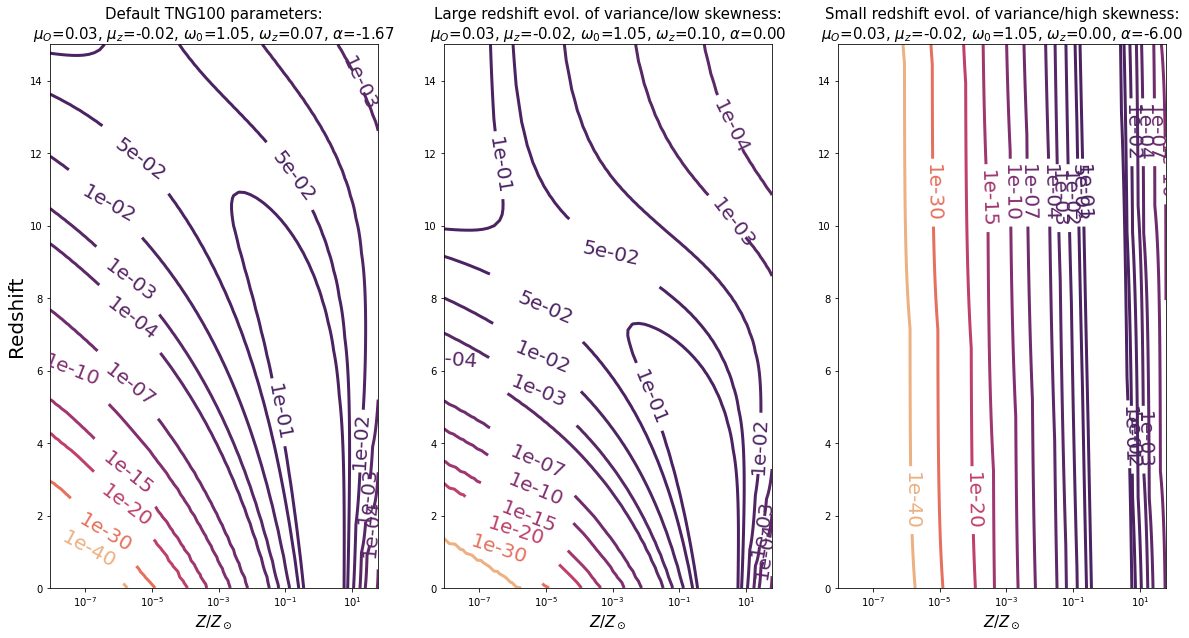

In [106]:
#Plot dP/dlogZ as a 2D plot

from matplotlib import ticker, cm
import seaborn as sns
fig, ax = plt.subplots(1, 3, figsize = (20,10))
levels = [1e-40, 1e-30, 1e-20, 1e-15, 1e-10, 1e-7, 1e-4,1e-3,1e-2,5e-2,1e-1]
cmap = sns.color_palette('flare', as_cmap=True)

cs = ax[0].contour(metallicities/Zsun, redshift_list, dPdlogZ, levels, cmap=cmap, linewidths=3, locator=ticker.LogLocator())
ax[0].clabel(cs,inline=1,levels = levels, fontsize=20, use_clabeltext=True, fmt = '%.0e')

ax[0].set_xlabel(r"$Z/Z_\odot$", fontsize=15)
ax[0].set_xscale("log")
ax[0].set_ylabel('Redshift', fontsize = 20)
ax[0].set_title('Default TNG100 parameters:'+'\n'+r'$\mu_O$=%.2f, $\mu_z$=%.2f, $\omega_0$=%.2f, $\omega_z$=%.2f, $\alpha$=%.2f'%(mu0, muz, omega0, omegaz, alpha0), fontsize=15)

cs = ax[1].contour(metallicities/Zsun, redshift_list, dPdlogZ3, levels, cmap=cmap, linewidths=3, locator=ticker.LogLocator())
ax[1].clabel(cs,inline=1,levels = levels, fontsize=20, use_clabeltext=True, fmt = '%.0e')

ax[1].set_xlabel(r"$Z/Z_\odot$", fontsize=15)
ax[1].set_xscale("log")
ax[1].set_title('Large redshift evol. of variance/low skewness:'+'\n'+r'$\mu_O$=%.2f, $\mu_z$=%.2f, $\omega_0$=%.2f, $\omega_z$=%.2f, $\alpha$=%.2f'%(mu0, muz, omega0, 0.1, 0), fontsize=15)

cs = ax[2].contour(metallicities/Zsun, redshift_list, dPdlogZ4, levels, cmap=cmap, linewidths=3, locator=ticker.LogLocator())
ax[2].clabel(cs,inline=1,levels = levels, fontsize=20, use_clabeltext=True, fmt = '%.0e')

ax[2].set_xlabel(r"$Z/Z_\odot$", fontsize=15)
ax[2].set_xscale("log")
ax[2].set_title('Small redshift evol. of variance/high skewness:'+'\n'+r'$\mu_O$=%.2f, $\mu_z$=%.2f, $\omega_0$=%.2f, $\omega_z$=%.2f, $\alpha$=%.2f'%(mu0, muz, omega0, 0, -6), fontsize=15);

fig.savefig('figures/checking_fit/parameter_variations_2D.png', bbox_inches='tight')

# SFRD(Z, z)

In [107]:
#get data SFRD

with h5.File("data/SFRMetallicityFromGasTNG50-1.hdf5", "r") as f:
    MetalBins     = f["MetalBins"][:]
    Lookbacktimes = f["Lookbacktimes"][:]
    BoxSfr        = f["Sfr"][:]
    Redshifts     = f["Redshifts"][:]
littleh  = 0.6774
Rbox     = 35/littleh
Sim_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
Sim_SFRD = Sim_SFRD.value

In [108]:
#get fitted model SFRD

redshift_list  = np.linspace(0,15, num=100)
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = Z_SFRD.skew_metallicity_distribution(redshift_list, mu_z =muz, 
                                                        mu_0 =mu0, omega_0=omega0,omega_z=omegaz, alpha =alpha0, metals=center_Zbin)
sfr = Z_SFRD.Madau_Dickinson2014(redshift_list, a=sf_a, b=sf_b, c=sf_c,  d=sf_d) #test with M&F 2017 vals
SFRD = (sfr* (dPdlogZ * step_logZ ).T).value

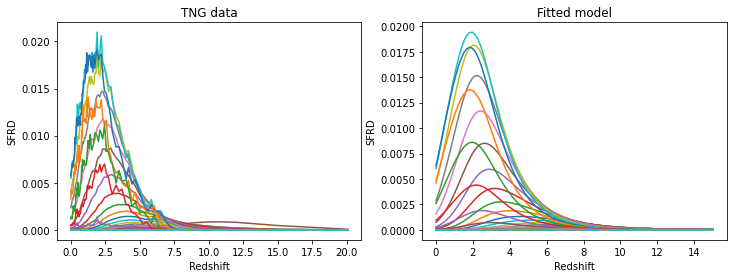

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(Redshifts, Sim_SFRD)
ax[0].set_xlabel('Redshift')
ax[0].set_ylabel("SFRD")
ax[0].set_title('TNG data')

ax[1].plot(redshift_list, SFRD.T)
ax[1].set_xlabel('Redshift')
ax[1].set_ylabel("SFRD")
ax[1].set_title('Fitted model');

# Testing parameters

In [110]:
#set up data 

Sim_SFRD, Lookbacktimes, Sim_center_Zbin, step_fit_logZ, Redshifts = read.load_TNG(loc = Cosmol_sim_location, rbox=rbox)

minZ_popSynth    =  1e-6
tofit_Sim_metals = Sim_center_Zbin[np.where(Sim_center_Zbin > minZ_popSynth)[0]]   
tofit_Sim_SFRD      = Sim_SFRD[:,np.where(Sim_center_Zbin > minZ_popSynth)[0]][::-1]
tofit_Sim_lookbackt = Lookbacktimes[::-1] 
redshifts_Sim = Redshifts

f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')
redshift_new         = np.arange(0, 10.1, 0.05)
Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new]
log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 500)

SFRDnew = f_interp(Lookbacktimes_new,metals_new)

## PCA

In [111]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
from random import randrange
from sklearn.preprocessing import StandardScaler

#performing the PCA
def doPCA(componentsNo, data):
    pca = PCA(componentsNo)
    dataInPCABasis = pca.fit_transform(data)
    return pca, dataInPCABasis

In [112]:
n_components=10 #number of PCA components to calculate
data_normalized = SFRDnew - np.mean(SFRDnew, axis=0)
pca,dataInPCABasis=doPCA(n_components,SFRDnew)
eigenvectors=pca.components_
eigenvalues=pca.explained_variance_

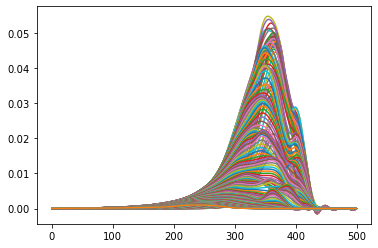

In [113]:
plt.plot(SFRDnew);

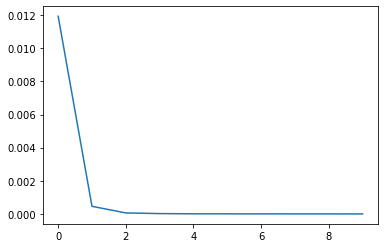

In [114]:
plt.plot(eigenvalues);

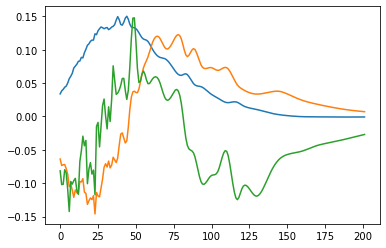

In [115]:
for i in range(0,3):
    plt.plot(eigenvectors[i]);

In [116]:
omegaz_temp = 0
omega = omega0* 10**(omegaz_temp*redshift_list)
omega

array([1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257313,
       1.05257313, 1.05257313, 1.05257313, 1.05257313, 1.05257

## MCMC

In [117]:
import emcee
import corner

In [118]:
def log_prob(x, mu, cov): #returns density for specific parameters; x is position of single walker
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

In [119]:
#set up values of hyperparameters in ndim dimensions
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

In [120]:
#set up starting position of walkers
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

In [121]:
#create sampler object 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

In [122]:
#let walkers explore parameter space; burn-in of 100 steps and save final position
state = sampler.run_mcmc(p0, 100) #save new starting location of walkers
sampler.reset() #resets to get a fresh start

In [123]:
sampler.run_mcmc(state, 10000); #run mcmc with 10000 steps

The samples can be accessed using the EnsembleSampler.get_chain() method. This will return an array with the shape (10000, 32, 5) giving the parameter values for each walker at each step in the chain:

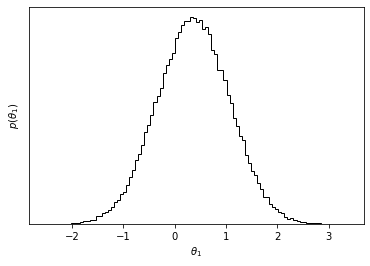

In [124]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [31]:
#Helps check if sampling went well
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time())))

Mean acceptance fraction: 0.552
Mean autocorrelation time: 57.112 steps


In [32]:
#likelihood function
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [33]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [34]:
(-1., 0), (0.001, 0.1), (0.01, 5), (0, 1.), (-10, 0)

((-1.0, 0), (0.001, 0.1), (0.01, 5), (0, 1.0), (-10, 0))

In [35]:
def model(theta, redshifts, metals):
    mu0, muz, omega0, omegaz, alpha, sf_a, sf_b, sf_c, sf_d = theta
    
    dPdlogZ, metallicities, step_logZ, p_draw_metallicity = Z_SFRD.skew_metallicity_distribution(redshifts, mu_z =muz, 
                                                        mu_0 =mu0, omega_0=omega0,omega_z=omegaz, alpha =alpha, metals=metals)
    sfr = Z_SFRD.Madau_Dickinson2014(redshifts, a=sf_a, b=sf_b, c=sf_c,  d=sf_d) #test with M&F 2017 vals
    
    return (sfr* (dPdlogZ * step_logZ ).T).value

def lnlike(theta, redshifts, metals, y, yerr):
    return -0.5 * np.sum(((y - model(theta, redshifts, metals))/yerr) ** 2)
    
def lnprior(theta):
    mu0, muz, omega0, omegaz, alpha, sf_a, sf_b, sf_c, sf_d = theta
    
    if 0.001 < mu0 < 0.1 and -1.0 < muz < 0.0 and 0.01 < omega0 < 5.0 and 0.0 < omega0 < 1.0 and -10.0 < alpha < 0.0: #and 0 < sf_a < 1 and 0 < sf_b < 10 and 0 < sf_c < 10 and 0 < sf_d < 10:
        return 0.0
    return -np.inf

def lnprob(theta, redshifts, metals, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, redshifts, metals, y, yerr)

In [36]:
SFRD_err = 0.1*np.mean(SFRDnew)
data = (redshift_new, metals_new, SFRDnew, SFRD_err)
nwalkers = 1000
niter = 20000
initial = np.array([-0.15, 0.026, 1.1, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2])
initial = np.array([mu0, muz, omega0, omegaz, alpha0, sf_a, sf_b, sf_c, sf_d])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [37]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 200)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [38]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


/Users/sashalvna/anaconda3/envs/compas/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Running production...


In [39]:
sampler.flatchain[np.argmax(sampler.flatlnprobability)]

array([ 0.0263539 , -0.02221015,  1.05082229,  0.06687064, -1.65529154,
        0.0311482 ,  1.54957491,  3.74833546,  4.98910041])

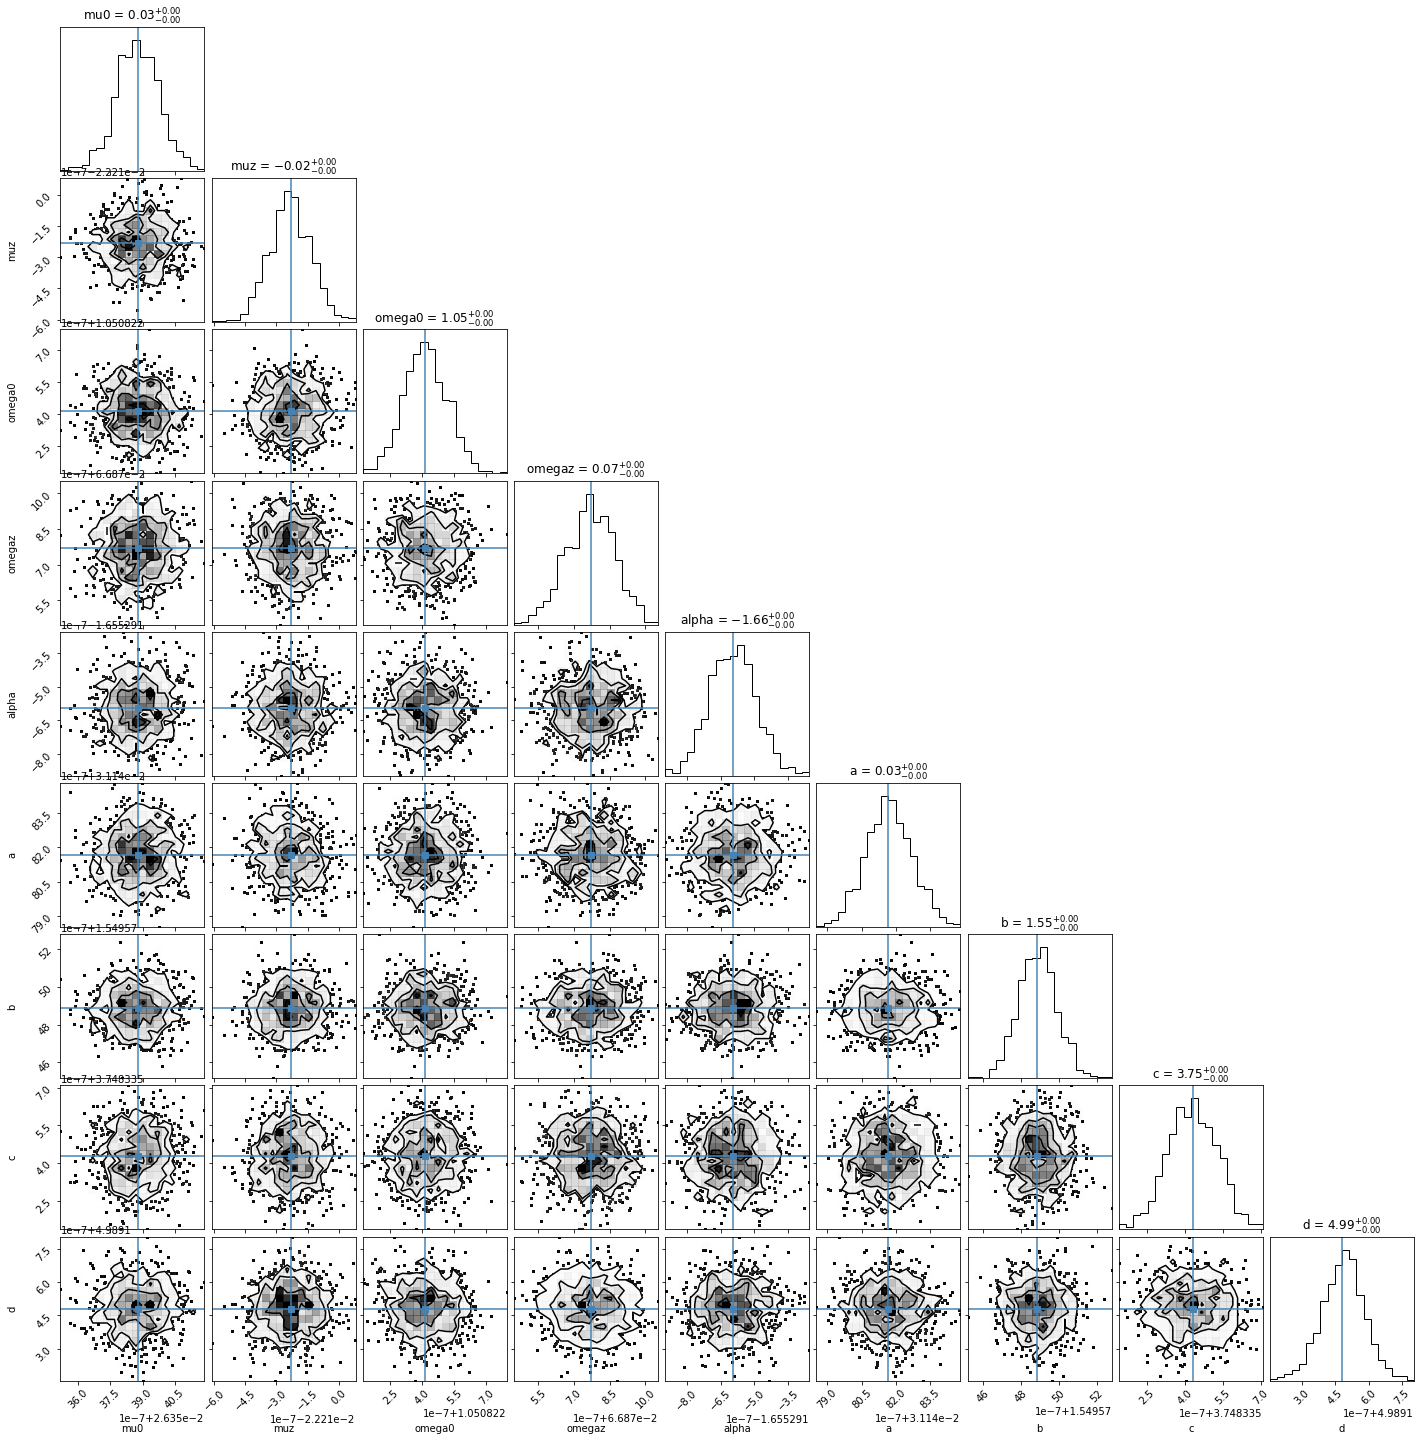

In [40]:
labels = ['mu0','muz','omega0','omegaz','alpha','a','b','c','d']
fig = corner.corner(sampler.flatchain,show_titles=True, labels=labels, truths=[mu0, muz, omega0, omegaz, alpha0, sf_a, sf_b, sf_c, sf_d])
fig.savefig("cornerplot.png")

Theta max:  [ 0.0263539  -0.02221015  1.05082229  0.06687064 -1.65529154  0.0311482
  1.54957491  3.74833546  4.98910041]


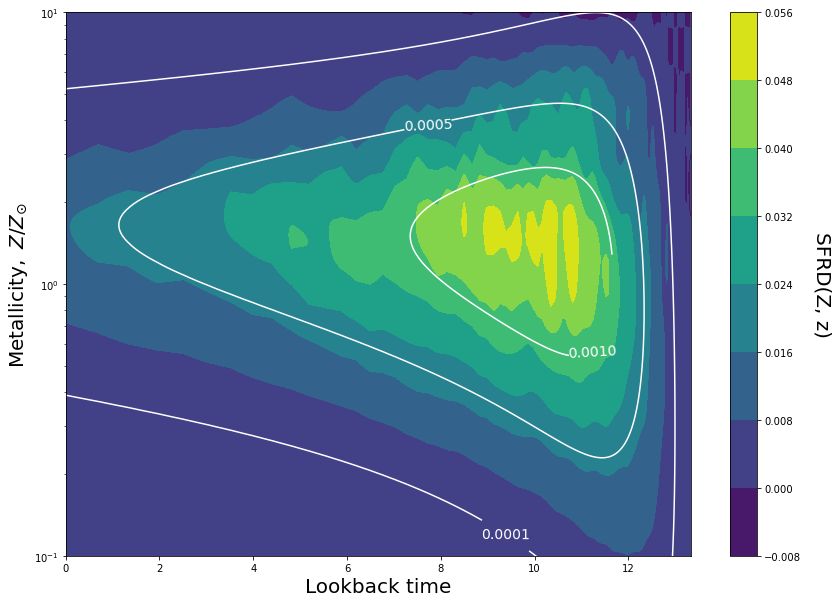

In [97]:
new_theta_max  = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
new_best_fit_model = model(new_theta_max, redshift_new, metals_new)

fig, ax = plt.subplots(figsize = (14, 10))

#levels = np.linspace(0, 0.055, 20)
clevels = [1e-4, 0.0005, 1e-3, 0.01]

data = ax.contourf(Lookbacktimes_new, metals_new/Zsun, SFRDnew)
modelplot = ax.contour(Lookbacktimes_new, metals_new/Zsun, new_best_fit_model, levels = clevels, colors='white')
ax.clabel(modelplot, fontsize=14, inline=True)

ax.set_ylim(10**-1, 10**1)
ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
cbar = fig.colorbar(data)
cbar.set_label('SFRD(Z, z)', rotation=270,fontsize=20, labelpad=30);

print('Theta max: ',new_theta_max)

In [41]:
def sample_walkers(nsamples,flattened_chain, redshifts, metals):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i, redshifts, metals)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100, sampler.flatchain, redshift_new, metals_new)

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_98023/3178484899.py:10: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(data, orientation='horizontal')


Text(0, 0.5, '$\\mathrm{Metallicity}, \\ Z/Z_{\\rm{\\odot}}$')

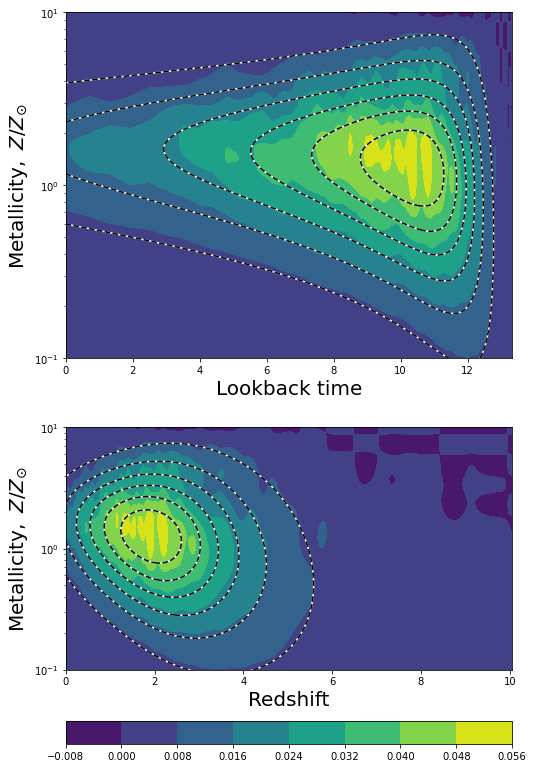

In [42]:
fig, ax = plt.subplots(2, 1, figsize = (8,14))

data = ax[0].contourf(Lookbacktimes_new, metals_new/Zsun, SFRDnew)
ax[0].contour(Lookbacktimes_new, metals_new/Zsun, med_model-spread, colors='white')
ax[0].contour(Lookbacktimes_new, metals_new/Zsun, med_model+spread, colors='black', linestyles='dashed')
ax[0].set_ylim(10**-1, 10**1)
ax[0].set_yscale('log')
ax[0].set_xlabel('Lookback time', fontsize=20)
ax[0].set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
fig.colorbar(data, orientation='horizontal')

data1 = ax[1].contourf(redshift_new, metals_new/Zsun, SFRDnew)
ax[1].contour(redshift_new, metals_new/Zsun, med_model-spread, colors='white')
ax[1].contour(redshift_new, metals_new/Zsun, med_model+spread, colors='black', linestyles='dashed')
ax[1].set_ylim(10**-1, 10**1)
ax[1].set_yscale('log')
ax[1].set_xlabel('Redshift', fontsize=20)
ax[1].set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)

In [ ]:
def lnprior(theta):
    # The parameters are stored as a vector of values, so unpack them
    mu0, muz, omega0, omegaz, alpha, sf_a, sf_b, sf_c, sf_d = theta
    
    if -1.0 < muz < 0.0 and 0.001 < mu0 < 0.1 and 0.01 < omega0 < 5.0 and 0.0 < omega0 < 1.0 and -10.0 < alpha < 0.0:
        return 0.0
    return -np.inf

def lnlike(theta, redshifts, metals, SFRD_Z_z):
    mu0, muz, omega0, omegaz, alpha, sf_a, sf_b, sf_c, sf_d = theta
    
    # the likelihood is sum of the lot of normal distributions
    denom = power(eps,2)
    lp = -0.5*sum(power((SFRD_Z_z - model),2)/denom + log(denom) + log(2*pi))
    
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((SFRD_Z_z - model) ** 2 / sigma2 + np.log(sigma2))
    
    return lp

def lnprob(theta, redshifts, metals, SFRD_Z_z):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, redshifts, metals, SFRD_Z_z)